<a href="https://colab.research.google.com/github/Nithinarayan/Python/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

from google.colab import files
uploaded = files.upload()   # Upload your CSV file

# Replace the filename if needed
df = pd.read_csv(list(uploaded.keys())[0])

print("Dataset loaded successfully!")
print("Shape:", df.shape)
df.head()

Saving twitter_training.csv to twitter_training (1).csv
Dataset loaded successfully!
Shape: (74681, 4)


,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [3]:
import pandas as pd
import re
from pathlib import Path
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer


default_session_path = "/content/twitter_training.csv"  # existing path from your session


csv_path = default_session_path

print("Loading CSV from:", csv_path)
df = pd.read_csv(csv_path)
print("Initial shape:", df.shape)
print("Columns:", list(df.columns))

# ---------- 1) Detect text column ----------
text_candidates = [c for c in df.columns if c.lower() in ("text","tweet","tweet_text","content","message","tweettext")]
if text_candidates:
    text_col = text_candidates[0]
else:
    # fallback: choose object dtype column with highest average length
    obj_cols = [c for c in df.columns if df[c].dtype == object]
    if not obj_cols:
        raise ValueError("No string-like column found to use as text column.")
    avg_len = {c: df[c].astype(str).str.len().mean() for c in obj_cols}
    text_col = max(avg_len, key=avg_len.get)

print("Selected text column:", text_col)

# ---------- 2) Check & handle missing values ----------
print("\nMissing values per column:")
print(df.isnull().sum())

# Drop rows where the text column is missing (common choice for text models)
before = len(df)
df = df[df[text_col].notna()].copy()
dropped = before - len(df)
print(f"Dropped {dropped} rows with missing {text_col}. New shape: {df.shape}")


# ---------- 3) Remove duplicates ----------
id_like = [c for c in df.columns if c.lower() in ('id','tweet_id','tweetid','tweet_id_str')]
dup_subset = [text_col] + [c for c in id_like if c in df.columns]
dups_before = df.duplicated(subset=dup_subset).sum()
if dups_before:
    df = df.drop_duplicates(subset=dup_subset).reset_index(drop=True)
    print(f"Removed {dups_before} duplicates using subset {dup_subset}. New shape: {df.shape}")
else:
    # fallback: drop duplicates based on text only
    dups_text = df.duplicated(subset=[text_col]).sum()
    if dups_text:
        df = df.drop_duplicates(subset=[text_col]).reset_index(drop=True)
        print(f"Removed {dups_text} duplicates based on text. New shape: {df.shape}")
    else:
        print("No duplicates detected.")

# ---------- 4) Text cleaning function ----------
url_re = re.compile(r'https?://\S+|www\.\S+')
mention_re = re.compile(r'@\w+')
hashtag_re = re.compile(r'#\w+')
html_re = re.compile(r'<.*?>')
special_re = re.compile(r'[^A-Za-z0-9\s]')    # removes punctuation and many emojis; tweak if you want to keep emojis
multi_space_re = re.compile(r'\s+')

def clean_tweet_text(text):
    # ensure string
    if not isinstance(text, str):
        text = str(text)
    text = url_re.sub(' ', text)
    text = mention_re.sub(' ', text)
    text = hashtag_re.sub(' ', text)
    text = html_re.sub(' ', text)
    text = special_re.sub(' ', text)
    text = text.lower()
    text = multi_space_re.sub(' ', text).strip()
    return text

# Apply cleaning to a new column 'cleaned_text'
print("\nCleaning text (this may take a moment on large datasets)...")
df['cleaned_text'] = df[text_col].apply(clean_tweet_text)

# Show a few examples
print("\nSample (original -> cleaned):")
for i, row in df[[text_col, 'cleaned_text']].head(8).iterrows():
    print(f"- ORIGINAL: {row[text_col]}")
    print(f"  CLEANED : {row['cleaned_text']}\n")

# ---------- 5) Save a processed sample ----------
out_dir = Path("/content/data")
out_dir.mkdir(parents=True, exist_ok=True)
sample_path = out_dir / "processed_sample.csv"
df[[text_col, 'cleaned_text']].head(200).to_csv(sample_path, index=False)
print("Saved processed sample to:", sample_path)

nltk.download('stopwords')
nltk.download('wordnet')

# Stopwords set
stop_words = set(stopwords.words('english'))

# Choose your preferred normalization method:
USE_LEMMATIZATION = False    # set to True to use lemmatizer instead of stemming

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def tokenize_and_normalize(text):
    # Tokenize (simple split, text is already lowercased)
    tokens = text.split()

    cleaned_tokens = []
    for token in tokens:
        # Skip stop words & numeric tokens
        if token in stop_words:
            continue
        if token.isnumeric():
            continue

        # Apply stemming or lemmatization
        if USE_LEMMATIZATION:
            token = lemmatizer.lemmatize(token)
        else:
            token = stemmer.stem(token)

        cleaned_tokens.append(token)

    return cleaned_tokens

# Apply tokenization + normalization
df["tokens"] = df["cleaned_text"].apply(tokenize_and_normalize)

# Preview
df[["cleaned_text", "tokens"]].head(10)

Loading CSV from: /content/twitter_training.csv
Initial shape: (74681, 4)
Columns: ['2401', 'Borderlands', 'Positive', 'im getting on borderlands and i will murder you all ,']
Selected text column: im getting on borderlands and i will murder you all ,

Missing values per column:
2401                                                       0
Borderlands                                                0
Positive                                                   0
im getting on borderlands and i will murder you all ,    686
dtype: int64
Dropped 686 rows with missing im getting on borderlands and i will murder you all ,. New shape: (73995, 4)
Removed 4505 duplicates using subset ['im getting on borderlands and i will murder you all ,']. New shape: (69490, 4)

Cleaning text (this may take a moment on large datasets)...

Sample (original -> cleaned):
- ORIGINAL: I am coming to the borders and I will kill you all,
  CLEANED : i am coming to the borders and i will kill you all

- ORIGINAL: im get

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,cleaned_text,tokens
0,i am coming to the borders and i will kill you...,"[come, border, kill]"
1,im getting on borderlands and i will kill you all,"[im, get, borderland, kill]"
2,im coming on borderlands and i will murder you...,"[im, come, borderland, murder]"
3,im getting on borderlands 2 and i will murder ...,"[im, get, borderland, murder]"
4,im getting into borderlands and i can murder y...,"[im, get, borderland, murder]"
5,so i spent a few hours making something for fu...,"[spent, hour, make, someth, fun, know, huge, f..."
6,so i spent a couple of hours doing something f...,"[spent, coupl, hour, someth, fun, know, huge, ..."
7,so i spent a few hours doing something for fun...,"[spent, hour, someth, fun, know, huge, borderl..."
8,so i spent a few hours making something for fu...,"[spent, hour, make, someth, fun, know, huge, r..."
9,2010 so i spent a few hours making something f...,"[spent, hour, make, someth, fun, know, huge, r..."


In [4]:


!pip install --quiet gensim

import os
from pathlib import Path
import pickle
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import gensim
from gensim.models import Word2Vec

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --- Configurable parameters ---
FALLBACK_CSV_PATH = "/content/twitter_training.csv"   # <- session file path (used if you don't upload)
ARTIFACT_DIR = "/content/feature_artifacts"
MAX_TFIDF_FEATURES = 5000
W2V_VECTOR_SIZE = 100
W2V_WINDOW = 5
W2V_MIN_COUNT = 2
W2V_EPOCHS = 10
TOKENIZER_VOCAB_SIZE = 10000
MAX_SEQ_LEN = 50   # padded sequence length

os.makedirs(ARTIFACT_DIR, exist_ok=True)


csv_fname = FALLBACK_CSV_PATH

df = pd.read_csv(csv_fname)
print("Loaded data shape:", df.shape)
print("Columns:", list(df.columns))

# --- Detect text column (common names or longest object column) ---
text_candidates = [c for c in df.columns if c.lower() in ("text","tweet","tweet_text","content","message","tweettext")]
if text_candidates:
    text_col = text_candidates[0]
else:
    obj_cols = [c for c in df.columns if df[c].dtype == object]
    if not obj_cols:
        raise ValueError("No string-like column found to use as text column.")
    lengths = {c: df[c].astype(str).str.len().mean() for c in obj_cols}
    text_col = max(lengths, key=lengths.get)

print("Selected text column:", text_col)

# --- Basic cleaning (if cleaned_text not already present) ---
import re
url_re = re.compile(r'https?://\S+|www\.\S+')
mention_re = re.compile(r'@\w+')
hashtag_re = re.compile(r'#\w+')
html_re = re.compile(r'<.*?>')
special_re = re.compile(r'[^A-Za-z0-9\s]')    # remove punctuation and many emojis
multi_space_re = re.compile(r'\s+')

def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = url_re.sub(' ', text)
    text = mention_re.sub(' ', text)
    text = hashtag_re.sub(' ', text)
    text = html_re.sub(' ', text)
    text = special_re.sub(' ', text)
    text = text.lower()
    text = multi_space_re.sub(' ', text).strip()
    return text

if 'cleaned_text' not in df.columns:
    print("Applying cleaning to create 'cleaned_text' column...")
    df['cleaned_text'] = df[text_col].apply(clean_text)
else:
    print("'cleaned_text' already present — skipping raw cleaning step.")

# --- Tokenization + stopword removal + lemmatization ---
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    # basic whitespace tokenize (cleaned_text already lowercased)
    toks = text.split()
    out = []
    for t in toks:
        if t in stop_words:           # drop stopwords
            continue
        if t.isnumeric():             # drop pure numbers
            continue
        # lemma
        t = lemmatizer.lemmatize(t)
        if len(t) > 1:
            out.append(t)
    return out

print("Tokenizing & lemmatizing...")
df['tokens'] = df['cleaned_text'].astype(str).apply(tokenize_and_lemmatize)
# also produce a joined string column for vectorizers
df['cleaned_joined'] = df['tokens'].apply(lambda toks: " ".join(toks))

print("Sample tokens:")
print(df[['cleaned_text','tokens']].head(4).to_dict(orient='records'))

# --- 1) TF-IDF features ---
print("\n[TF-IDF] Fitting TfidfVectorizer (max_features=%d)..." % MAX_TFIDF_FEATURES)
tfidf = TfidfVectorizer(max_features=MAX_TFIDF_FEATURES)
X_tfidf = tfidf.fit_transform(df['cleaned_joined'].values)
print("TF-IDF shape:", X_tfidf.shape)

# Save TF-IDF vectorizer to disk (pickle)
tfidf_path = os.path.join(ARTIFACT_DIR, "tfidf_vectorizer.pkl")
with open(tfidf_path, "wb") as f:
    pickle.dump(tfidf, f)
print("Saved TF-IDF vectorizer to:", tfidf_path)

# --- 2) Word2Vec: train on tokens and build averaged tweet embeddings ---
print("\n[Word2Vec] Training Word2Vec (size=%d, window=%d, min_count=%d, epochs=%d) ..." %
      (W2V_VECTOR_SIZE, W2V_WINDOW, W2V_MIN_COUNT, W2V_EPOCHS))

# Prepare sentences as list of token lists
sentences = df['tokens'].tolist()
w2v_model = Word2Vec(sentences=sentences,
                     vector_size=W2V_VECTOR_SIZE,
                     window=W2V_WINDOW,
                     min_count=W2V_MIN_COUNT,
                     workers=4,
                     epochs=W2V_EPOCHS,
                     sg=1)   # use skip-gram (sg=1) — change to sg=0 for CBOW

print("Word2Vec vocab size:", len(w2v_model.wv))

# Create average embedding per tweet
def average_embedding(tokens, model, vector_size):
    vec = np.zeros(vector_size, dtype=np.float32)
    n = 0
    for t in tokens:
        if t in model.wv:
            vec += model.wv[t]
            n += 1
    if n > 0:
        vec /= n
    return vec

print("Computing average Word2Vec embeddings for each tweet (this may take some time)...")
X_w2v = np.vstack([average_embedding(toks, w2v_model, W2V_VECTOR_SIZE) for toks in df['tokens'].tolist()])
print("Word2Vec-averaged embedding matrix shape:", X_w2v.shape)

# Save Word2Vec model and averaged embeddings
w2v_model_path = os.path.join(ARTIFACT_DIR, "word2vec.model")
w2v_model.save(w2v_model_path)
np.save(os.path.join(ARTIFACT_DIR, "X_word2vec_avg.npy"), X_w2v)
print("Saved Word2Vec model to:", w2v_model_path)
print("Saved averaged embeddings to:", os.path.join(ARTIFACT_DIR, "X_word2vec_avg.npy"))

# --- 3) Keras Tokenizer -> sequences and padded arrays (for RNN/LSTM input) ---
print("\n[Keras Tokenizer] Fitting tokenizer (vocab_size=%d) and creating padded sequences (maxlen=%d)..." %
      (TOKENIZER_VOCAB_SIZE, MAX_SEQ_LEN))
tokenizer = Tokenizer(num_words=TOKENIZER_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_joined'].values)
sequences = tokenizer.texts_to_sequences(df['cleaned_joined'].values)
X_seq = pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
print("Sequences shape:", X_seq.shape)
print("Tokenizer num words (len word_index):", len(tokenizer.word_index))

# Save tokenizer (json) and padded sequences
tokenizer_json_path = os.path.join(ARTIFACT_DIR, "tokenizer.json")
with open(tokenizer_json_path, "w", encoding="utf-8") as f:
    f.write(tokenizer.to_json())
np.save(os.path.join(ARTIFACT_DIR, "X_sequences_padded.npy"), X_seq)
print("Saved tokenizer to:", tokenizer_json_path)
print("Saved padded sequences to:", os.path.join(ARTIFACT_DIR, "X_sequences_padded.npy"))

# --- Optionally create embedding matrix for Keras using trained Word2Vec (to initialize Embedding layer) ---
print("\nBuilding embedding matrix for Keras Embedding layer from trained Word2Vec...")
vocab_size_used = min(TOKENIZER_VOCAB_SIZE, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((vocab_size_used, W2V_VECTOR_SIZE), dtype=np.float32)
for word, i in tokenizer.word_index.items():
    if i >= vocab_size_used:
        continue
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
# Save embedding matrix
np.save(os.path.join(ARTIFACT_DIR, "embedding_matrix.npy"), embedding_matrix)
print("Saved embedding matrix shape:", embedding_matrix.shape, "->", os.path.join(ARTIFACT_DIR, "embedding_matrix.npy"))

# --- Summary of outputs ---
print("\n=== SUMMARY ===")
print("TF-IDF matrix shape:", X_tfidf.shape)
print("Word2Vec averaged embeddings shape:", X_w2v.shape)
print("Padded sequences shape:", X_seq.shape)
print("Artifacts saved to:", ARTIFACT_DIR)
print("Files in artifact dir:", os.listdir(ARTIFACT_DIR))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 76.1 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loaded data shape: (74681, 4)
Columns: ['2401', 'Borderlands', 'Positive', 'im getting on borderlands and i will murder you all ,']
Selected text column: im getting on borderlands and i will murder you all ,
Applying cleaning to create 'cleaned_text' column...
Tokenizing & lemmatizing...
Sample tokens:
[{'cleaned_text': 'i am coming to the borders and i will kill you all', 'tokens': ['coming', 'border', 'kill']}, {'cleaned_text': 'im getting on borderlands and i will kill you all', 'tokens': ['im', 'getting', 'borderland', 'kill']}, {'cleaned_text': 'im coming on borderlands and i will murder you all', 'tokens': ['im', 'coming', 'borderland', 'murder']}, {'cleaned_text': 'im getting on borderlands 2 and i will murder you me all', 'tokens': ['im', 'getting', 'borderland', 'murder']}]

[TF-IDF] Fitting TfidfVectorizer (max_features=5000)...
TF-IDF shape: (74681, 5000)
Saved TF-IDF vectorizer to: /content/feature_artifacts/tfidf_vectorizer.pkl

[Word2Vec] Training Word2Vec (size=100, wind

Dataset loaded successfully!
Shape: (74681, 4)
Columns: ['2401', 'Borderlands', 'Positive', 'im getting on borderlands and i will murder you all ,']

===== DATASET INFO =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   2401                                                   74681 non-null  int64 
 1   Borderlands                                            74681 non-null  object
 2   Positive                                               74681 non-null  object
 3   im getting on borderlands and i will murder you all ,  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB

===== NUMERIC SUMMARY (mean, median, std etc.) =====
                2401 Borderlands  Positive  \
count   74681.000000       74681     74681   
unique           NaN   

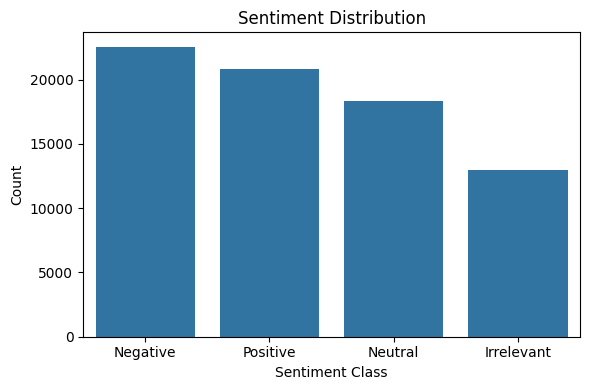

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Load dataset
csv_path = "/content/twitter_training.csv"   # change if you upload manually
df = pd.read_csv(csv_path)

print("Dataset loaded successfully!")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())


print("\n===== DATASET INFO =====")
df.info()

print("\n===== NUMERIC SUMMARY (mean, median, std etc.) =====")
print(df.describe(include='all'))   # includes numeric + object info

# ============================
# 2. MEAN & MEDIAN (numeric only)
# ============================
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

if len(numeric_cols) == 0:
    print("\nNo numeric columns found for mean/median.")
else:
    print("\n===== MEAN OF NUMERIC COLUMNS =====")
    print(df[numeric_cols].mean())

    print("\n===== MEDIAN OF NUMERIC COLUMNS =====")
    print(df[numeric_cols].median())

# ============================
# 3. MODE (most frequent values)
# ============================
print("\n===== MODE (most frequent values per column) =====")
try:
    print(df.mode().head(1))     # first most-common value
except:
    print("Mode calculation not available for some columns.")

# ============================
# 4. MISSING VALUE SUMMARY
# ============================
print("\n===== MISSING VALUES PER COLUMN =====")
print(df.isnull().sum())



# Load dataset
csv_path = "/content/twitter_training.csv"   # or replace with your upload
df = pd.read_csv(csv_path)

print("Dataset loaded!")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# ------------------------------------------
# Detect sentiment column automatically
# ------------------------------------------
sentiment_candidates = [c for c in df.columns if c.lower() in
                        ("sentiment", "label", "class", "target")]

# If not found, search for common labels inside columns
if not sentiment_candidates:
    for col in df.columns:
        values = df[col].astype(str).str.lower().unique()
        if any(v in ["positive", "negative", "neutral", "irrelevant"] for v in values):
            sentiment_candidates.append(col)

if not sentiment_candidates:
    raise ValueError("❌ Could not detect sentiment column. Please specify manually.")

sentiment_col = sentiment_candidates[0]
print("Detected sentiment column:", sentiment_col)

# ------------------------------------------
# Sentiment distribution
# ------------------------------------------
sent_counts = df[sentiment_col].value_counts()
print("\n===== SENTIMENT DISTRIBUTION =====")
print(sent_counts)

# ------------------------------------------
# Bar chart
# ------------------------------------------
plt.figure(figsize=(6,4))
sns.countplot(x=df[sentiment_col], order=sent_counts.index)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Sentiment column detected: Positive


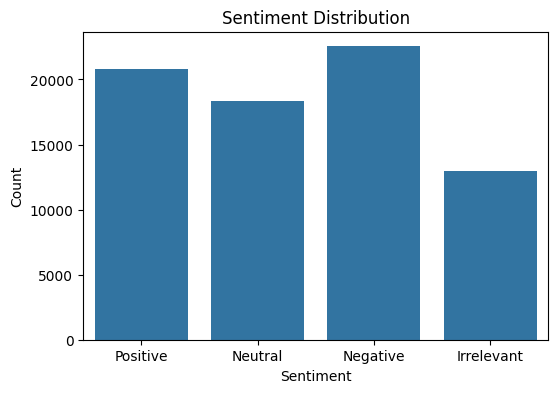

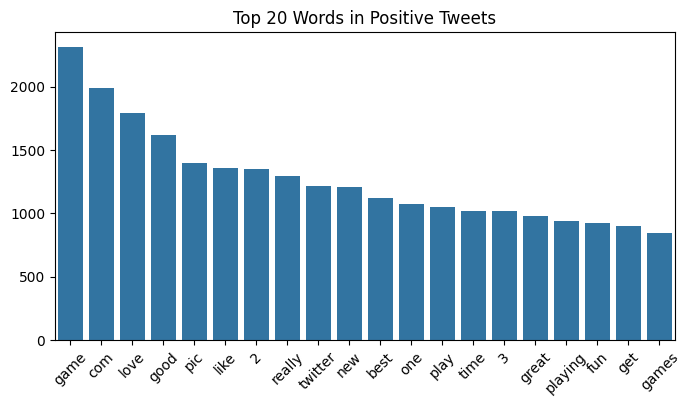

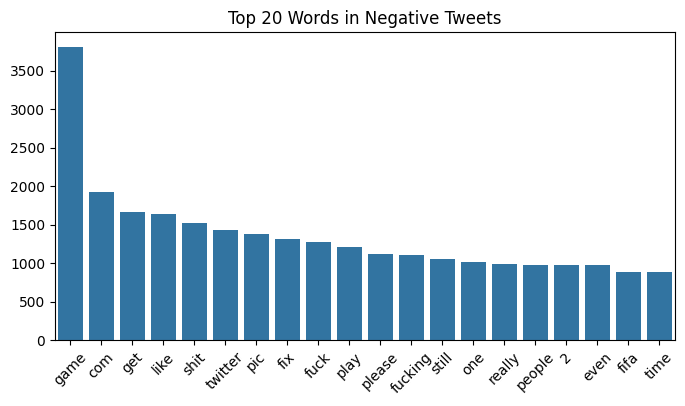

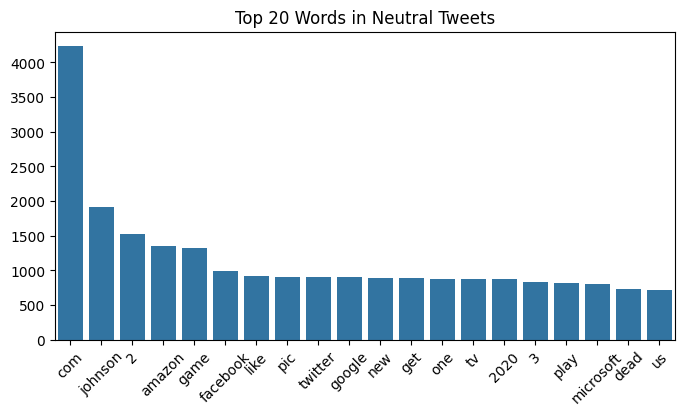

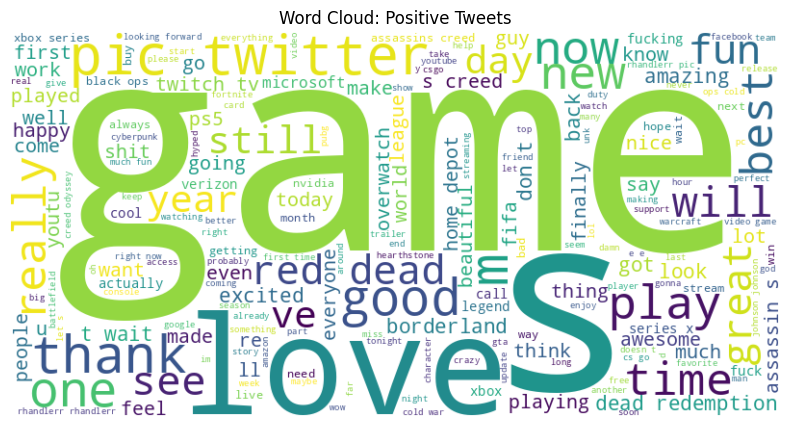

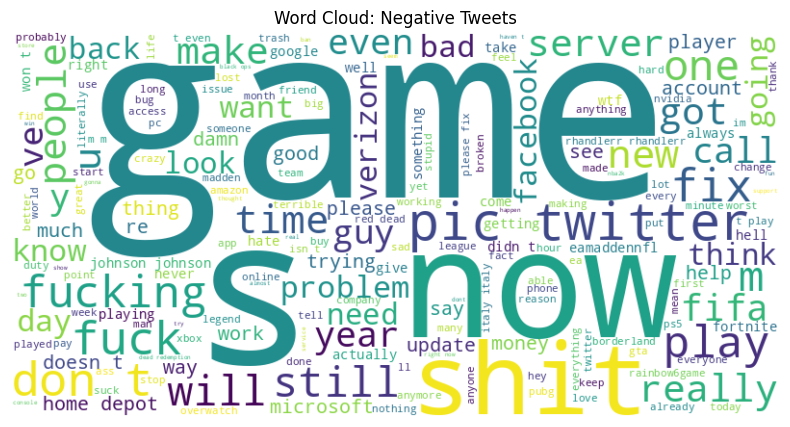

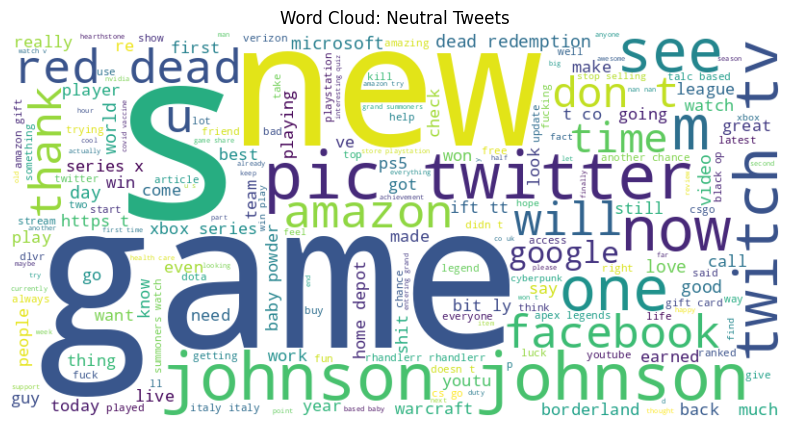

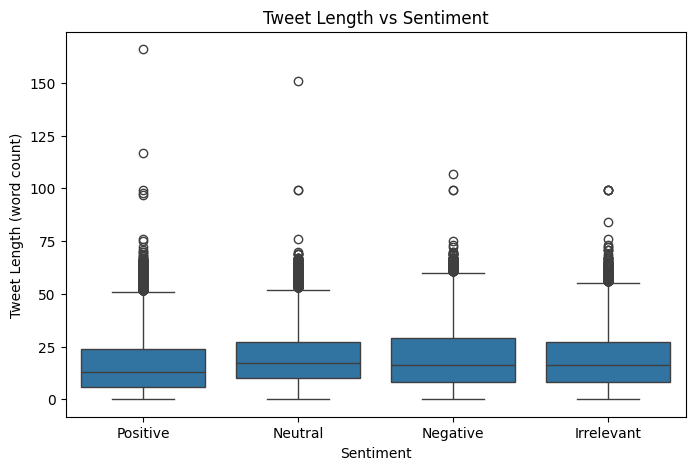

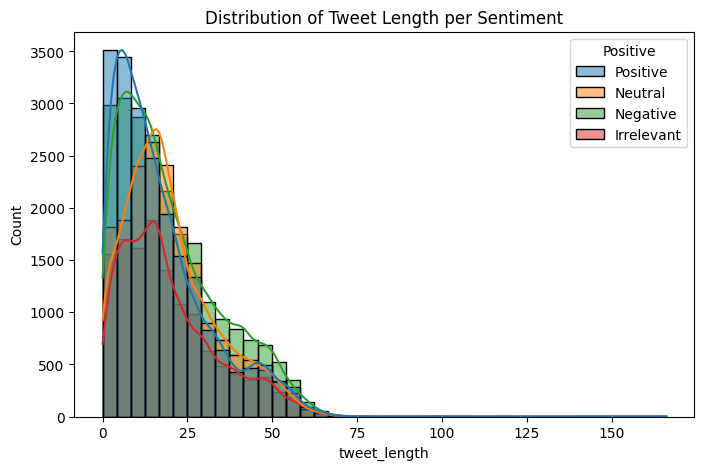

In [6]:
# ================================
# VISUALISATIONS FOR TWITTER EDA
# ================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

# Load dataset
csv_path = "/content/twitter_training.csv"
df = pd.read_csv(csv_path)

# ------------------------------------------
# Detect sentiment column
# ------------------------------------------
sentiment_candidates = [c for c in df.columns if c.lower() in ("sentiment","label","target","class")]
if not sentiment_candidates:
    for col in df.columns:
        values = df[col].astype(str).str.lower().unique()
        if any(v in ["positive","negative","neutral","irrelevant"] for v in values):
            sentiment_candidates.append(col)

sentiment_col = sentiment_candidates[0]
print("Sentiment column detected:", sentiment_col)

# Ensure cleaned_text exists
import re
url_re = re.compile(r'https?://\S+|www\.\S+')
mention_re = re.compile(r'@\w+')
hashtag_re = re.compile(r'#\w+')
html_re = re.compile(r'<.*?>')
special_re = re.compile(r'[^A-Za-z0-9\s]')
multi_space = re.compile(r'\s+')

def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = url_re.sub(' ', text)
    text = mention_re.sub(' ', text)
    text = hashtag_re.sub(' ', text)
    text = html_re.sub(' ', text)
    text = special_re.sub(' ', text)
    text = text.lower()
    return multi_space.sub(' ', text).strip()

df["cleaned_text"] = df.iloc[:, -1] if "cleaned_text" not in df.columns else df["cleaned_text"]
df["cleaned_text"] = df["cleaned_text"].apply(clean_text)

df["tokens"] = df["cleaned_text"].apply(lambda x: [t for t in x.split() if t not in stop_words])


# -----------------------------------------------------------
# 1. SENTIMENT DISTRIBUTION
# -----------------------------------------------------------
plt.figure(figsize=(6,4))
sns.countplot(x=df[sentiment_col])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


# -----------------------------------------------------------
# 2. FREQUENCY OF TOP WORDS PER SENTIMENT
# -----------------------------------------------------------
def plot_top_words(sentiment, top_n=20):
    tokens = df[df[sentiment_col] == sentiment]["tokens"].sum()
    word_freq = Counter(tokens).most_common(top_n)
    words, counts = zip(*word_freq)

    plt.figure(figsize=(8,4))
    sns.barplot(x=list(words), y=list(counts))
    plt.title(f"Top {top_n} Words in {sentiment} Tweets")
    plt.xticks(rotation=45)
    plt.show()

# Plot for positive, negative, neutral
plot_top_words("Positive")
plot_top_words("Negative")
plot_top_words("Neutral")


# -----------------------------------------------------------
# 3. WORD CLOUDS FOR POSITIVE, NEGATIVE, NEUTRAL
# -----------------------------------------------------------
def word_cloud(sentiment):
    text = " ".join(df[df[sentiment_col] == sentiment]["cleaned_text"])
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud: {sentiment} Tweets")
    plt.show()

word_cloud("Positive")
word_cloud("Negative")
word_cloud("Neutral")


# -----------------------------------------------------------
# 4. RELATIONSHIP BETWEEN TWEET LENGTH & SENTIMENT
# -----------------------------------------------------------
df["tweet_length"] = df["cleaned_text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
sns.boxplot(x=df[sentiment_col], y=df["tweet_length"])
plt.title("Tweet Length vs Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Length (word count)")
plt.show()

# Optional histogram
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="tweet_length", hue=sentiment_col, kde=True, bins=40)
plt.title("Distribution of Tweet Length per Sentiment")
plt.show()


In [7]:

import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional

print("TensorFlow version:", tf.__version__)

# ---------------------------------
# 1. Load dataset
# ---------------------------------
csv_path = "/content/twitter_training.csv"   # change if you upload manually in Colab
df = pd.read_csv(csv_path)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# ---------------------------------
# 2. Detect text & sentiment columns
# ---------------------------------
sentiment_col = "Positive"   # hard-coded for this dataset

# Detect text column: choose the object column with largest avg length
obj_cols = [c for c in df.columns if df[c].dtype == object]
lengths = {c: df[c].astype(str).str.len().mean() for c in obj_cols}
text_col = max(lengths, key=lengths.get)

print("Using text column:", text_col)
print("Using sentiment column:", sentiment_col)

# Drop rows with missing text or label
df = df[df[text_col].notna() & df[sentiment_col].notna()].copy()
df = df.reset_index(drop=True)
print("Shape after dropping NA:", df.shape)

# ---------------------------------
# 3. Basic text cleaning
# ---------------------------------
url_re = re.compile(r'https?://\S+|www\.\S+')
mention_re = re.compile(r'@\w+')
hashtag_re = re.compile(r'#\w+')
html_re = re.compile(r'<.*?>')
special_re = re.compile(r'[^A-Za-z0-9\s]')
multi_space = re.compile(r'\s+')

def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = url_re.sub(' ', text)
    text = mention_re.sub(' ', text)
    text = hashtag_re.sub(' ', text)
    text = html_re.sub(' ', text)
    text = special_re.sub(' ', text)
    text = text.lower()
    text = multi_space.sub(' ', text).strip()
    return text

df["cleaned_text"] = df[text_col].astype(str).apply(clean_text)

print("\nSample cleaned texts:")
print(df[["cleaned_text", sentiment_col]].head())

# ---------------------------------
# 4. Tokenization + Padding (for RNN input)
# ---------------------------------
MAX_VOCAB_SIZE = 10000
MAX_SEQ_LEN = 50  # tweets are short, 50 tokens is usually enough

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df["cleaned_text"].values)

sequences = tokenizer.texts_to_sequences(df["cleaned_text"].values)
X = pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding="post", truncating="post")

vocab_size = min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1)
print("\nVocab size (used):", vocab_size)
print("X shape (padded sequences):", X.shape)

# ---------------------------------
# 5. Encode sentiment labels
# ---------------------------------

label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(df[sentiment_col].values)
num_classes = len(label_encoder.classes_)

print("Classes:", label_encoder.classes_)
print("Encoded labels sample:", y_int[:10])

# One-hot encode for softmax output
y = tf.keras.utils.to_categorical(y_int, num_classes=num_classes)
print("y shape (one-hot):", y.shape)

# ---------------------------------
# 6. Train / Validation Split
# ---------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_int
)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

# ---------------------------------
# 7. Build RNN Model (LSTM) with Embedding
# ---------------------------------
EMBEDDING_DIM = 100

model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=MAX_SEQ_LEN),

    # You can use plain LSTM or Bidirectional LSTM
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),

    Dense(32, activation="relu"),
    Dropout(0.3),

    Dense(num_classes, activation="softmax")  # multi-class output
])


model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()


TensorFlow version: 2.19.0
Shape: (74681, 4)
Columns: ['2401', 'Borderlands', 'Positive', 'im getting on borderlands and i will murder you all ,']
Using text column: im getting on borderlands and i will murder you all ,
Using sentiment column: Positive
Shape after dropping NA: (73995, 4)

Sample cleaned texts:
                                        cleaned_text  Positive
0  i am coming to the borders and i will kill you...  Positive
1  im getting on borderlands and i will kill you all  Positive
2  im coming on borderlands and i will murder you...  Positive
3  im getting on borderlands 2 and i will murder ...  Positive
4  im getting into borderlands and i can murder y...  Positive

Vocab size (used): 10000
X shape (padded sequences): (73995, 50)
Classes: ['Irrelevant' 'Negative' 'Neutral' 'Positive']
Encoded labels sample: [3 3 3 3 3 3 3 3 3 3]
y shape (one-hot): (73995, 4)
Train shape: (59196, 50) (59196, 4)
Val shape: (14799, 50) (14799, 4)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
import matplotlib.pyplot as plt

print("Shapes:")
print("X_train:", X_train.shape)
print("X_val:  ", X_val.shape)
print("y_train:", y_train.shape)
print("y_val:  ", y_val.shape)

# ------------------------------------------------------
# 1. BUILD LSTM MODEL WITH DROPOUT + BATCH NORMALISATION
# ------------------------------------------------------

model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=MAX_SEQ_LEN),

    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.4),

    LSTM(32),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),

    Dense(num_classes, activation="softmax")
])

model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()

# ------------------------------------------------------
# 2. TRAIN THE MODEL
# ------------------------------------------------------

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

# ------------------------------------------------------
# 3. EVALUATE ON TEST SET
# ------------------------------------------------------

test_loss, test_acc = model.evaluate(X_val, y_val, verbose=1)
print("\n==============================================")
print(" TEST SET PERFORMANCE")
print(" Loss:", test_loss)
print(" Accuracy:", test_acc)
print("==============================================")

# ------------------------------------------------------
# 4. PLOT ACCURACY & LOSS
# ------------------------------------------------------

plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


Shapes:
X_train: (59196, 50)
X_val:   (14799, 50)
y_train: (59196, 4)
y_val:   (14799, 4)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 73s 143ms/step - accuracy: 0.3172 - loss: 1.5060 - val_accuracy: 0.5954 - val_loss: 1.0096
Epoch 2/10
